In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.linalg as sl

%matplotlib inline
import matplotlib
import librosa as rosa
import sounddevice as sd

import os
import sys

sys.path.append("..")
from src import AudioSignal
from src import utils as ut

In [73]:
def plot_mag_square_db(stft, 
                       duration_s, 
                       min_freq = 0, max_freq = 8000,
                       limit=True,
                       vmin=-60, vmax=30, 
                       figname=None):
    fig, ax = plt.subplots(1)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    
    if limit:
        pwr = np.maximum(np.abs(stft.T) ** 2, 10 ** (-15))
    else:
        pwr = np.abs(stft.T) ** 2
    
    im = ax.imshow(ut.lin_to_db(pwr),
                       cmap='viridis',
                       origin='lower',
                       extent=[0, duration_s, min_freq, max_freq],
                       aspect='auto',
                       vmin=vmin,
                       vmax=vmax)
    fig.colorbar(im)
    
    if figname is not None:
        plt.savefig(os.path.join(os.getcwd(), '../Exercise7', 'gfx', figname))

# 2 Delay-and-Sum Beamformer

In [62]:
sensor = AudioSignal(os.path.join(os.getcwd(), '../Exercise7', 'AudioFiles', 'noisySensor.wav'))
isotropic = AudioSignal(os.path.join(os.getcwd(), '../Exercise7', 'AudioFiles', 'noisyIsotropic.wav'))
directional = AudioSignal(os.path.join(os.getcwd(), '../Exercise7', 'AudioFiles', 'noisyDirectional.wav'))


/home/p0w3r/gitrepos/ssp20/notebooks/../Exercise7/AudioFiles/noisySensor.wav
Successfully loaded audio signal with 4 channel(s) from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise7/AudioFiles/noisySensor.wav
/home/p0w3r/gitrepos/ssp20/notebooks/../Exercise7/AudioFiles/noisyIsotropic.wav
Successfully loaded audio signal with 4 channel(s) from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise7/AudioFiles/noisyIsotropic.wav
/home/p0w3r/gitrepos/ssp20/notebooks/../Exercise7/AudioFiles/noisyDirectional.wav
Successfully loaded audio signal with 4 channel(s) from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise7/AudioFiles/noisyDirectional.wav


In [63]:
theta = np.pi / 4
d_m = 0.05
frame_length_ms = 128
frame_shift_ms = 32
a_window = np.sqrt(ss.get_window('hann', sensor.ms_to_idx(frame_length_ms), fftbins=True))
s_window = 0.5 * a_window
c_m_s = 340
M = 4

In [64]:
s_stft = np.array([sensor.compute_stft(frame_length_ms, frame_shift_ms, window=a_window, channel=i)[0] for i in range(M)])
i_stft = np.array([isotropic.compute_stft(frame_length_ms, frame_shift_ms, window=a_window, channel=i)[0] for i in range(M)])
d_stft = np.array([directional.compute_stft(frame_length_ms, frame_shift_ms, window=a_window, channel=i)[0] for i in range(M)])

In [65]:
print(s_stft.shape)

(4, 210, 1025)


### 2.1 compute time delay

In [66]:
time_delay = np.array([(i * d_m * np.cos(theta))/c_m_s for i in range(0, M)])

### 2.2 compute steering vector

In [67]:
def compute_steering_vetor(K, M = 4, theta = np.pi / 4, d_m = 0.05, c_m_s = 340, fs = 16000):
    # compute the time delay vector
    v_time_delay = np.array([(i * d_m * np.cos(theta))/c_m_s for i in range(0, M)])
    
    # compute steering vector
    
    # num of ALL freq bins 
    N = K * 2
    
    # init steering vector with dimensions: num_freq_bins x num_microphones
    a = np.zeros((K, M), dtype=np.complex)
    
    for k in range(K):
        for i in range (M):
            a[k, i] = 1 if i == 0 else np.exp((-1j * 2 * np.pi * k * fs * v_time_delay[i]) / N)
    
    return a

### Align the desired speech in all microphones and add up the delayed signals to obtain an estimate of the clean speech

In [68]:
def compute_delay_and_sum_enhanced_spectrum(s_stft):

    K = s_stft.shape[2]
    L = s_stft.shape[1]
    M = s_stft.shape[0]

    a = compute_steering_vetor(K, M)

    S_hat = np.zeros((L, K), dtype=np.complex)

    for l in range(L):
        for k in range(K):
            a_hermetian = np.conj(a[k, :].T)
            S_hat[l, k] =  np.matmul(a_hermetian, s_stft[:, l, k]) / M
            
    return S_hat

###  Plot the magnitude spectograms of the noisy signal in the leftmost microphone (i = 0) and of the speech estimate.

In [69]:
S_hat = compute_delay_and_sum_enhanced_spectrum(s_stft)

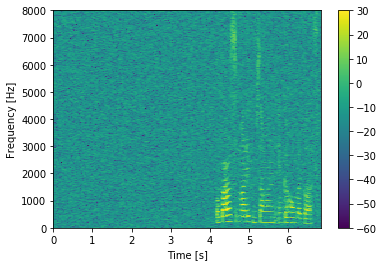

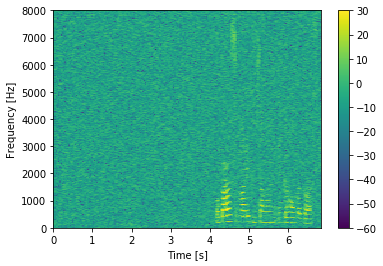

In [74]:
plot_mag_square_db(S_hat, sensor.duration_s, figname='s_enhanced_mag_square_spectrum_channel_0')
plot_mag_square_db(s_stft[0, ...], sensor.duration_s, figname='s_mag_square_spectrum_channel_0')

### Transform the speech estimate into the time domain via the inverse STFT. Listen to the results and compare it to the noisy recording. Has the noise been reduced relative to the unprocessed reference signal of microphone 0?


In [71]:
synth = ut.compute_istft(S_hat,
                         sampling_freq_hz=sensor.sampling_freq,
                         frame_shift_ms=frame_shift_ms, synthesis_window=s_window)
synth.play()

Successfully loaded audio signal with 1 channel!


In [72]:
sensor.play(channel=0)

# 3 Minimum Variance Distortionless Response (MVDR) Beamformer